## Introduction

This notebook builds on the out-of-fold (OOF) predictions from [this notebook](https://www.kaggle.com/code/masayakawamata/xgboost-add-random-features), where XGBoost was used to generate the OOFs. Here, those predictions are used to train a model using AutoGluon.

The overall structure is entirely based on the excellent work by @ravaghi in his [1st place solution notebook](https://www.kaggle.com/code/ravaghi/mental-health-prediction-1st-place-solution), to whom I owe great thanks.

One important note—also emphasized by @ravaghi himself in his [discussion post](https://www.kaggle.com/competitions/playground-series-s4e11/discussion/549160)—is that the folds used here are aligned with those used to generate the OOFs. This alignment is crucial to prevent data leakage.


In [1]:
!pip install -q autogluon.tabular ray==2.10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
import shutil
import glob

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e4/train.csv'
    test_path = '/kaggle/input/playground-series-s5e4/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e4/sample_submission.csv'
    
    oof_path = '/kaggle/input/podcast-oof'
    
    target = 'Listening_Time_minutes'
    n_folds = 5
    seed = 42
    
    time_limit = 3600 * 6

# Loading OOF Files

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [5]:
def get_data(path, X, y, CFG):
    oof_files  = sorted(glob.glob(os.path.join(path, 'oof_preds_*.csv')))
    test_files = sorted(glob.glob(os.path.join(path, 'test_preds_*.csv')))
    assert len(oof_files) == len(test_files), "oof と test の数が一致しません"

    oof_dict   = {}
    test_dict  = {}
    score_dict = {}

    for oof_fp, test_fp in zip(oof_files, test_files):
        version = os.path.basename(oof_fp) \
                     .replace('oof_preds_', '') \
                     .replace('.csv', '')

        oof_vals  = pd.read_csv(oof_fp)['oof'].to_numpy()
        test_vals = pd.read_csv(test_fp)['Listening_Time_minutes'].to_numpy()

        scores = []
        kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
        for _, val_idx in kf.split(X):
            y_true = y[val_idx]
            y_pred = oof_vals[val_idx]
            scores.append(mean_squared_error(y_true, y_pred, squared=False))

        oof_dict[version]   = oof_vals
        test_dict[version]  = test_vals
        score_dict[version] = scores

    return oof_dict, test_dict, score_dict

BASE_PATH = CFG.oof_path  # '/kaggle/input/podcast-oof' など

oof_preds, test_preds, scores = get_data(BASE_PATH, X, y, CFG)

for v in sorted(scores):
    print(v, scores[v])

v1 [12.331525733637443, 12.398686369727471, 12.358936034432155, 12.384899588489905, 12.356968029961324]
v10 [12.340713170424415, 12.40016440541216, 12.34781381121864, 12.366198778389448, 12.344695770902245]
v11 [12.338744844809929, 12.395745478846909, 12.357802925104439, 12.38488946882956, 12.343046822380519]
v12 [12.317600213567813, 12.382497956188844, 12.341810781401627, 12.365001373814657, 12.326425235724619]
v13 [12.39588649718577, 12.460712146136967, 12.445843664541233, 12.434617410202375, 12.403028682274158]
v14 [12.340639387688972, 12.401534844557053, 12.351849372134533, 12.38724362449623, 12.338972583183335]
v15 [12.307538964054547, 12.398613358811318, 12.356248135123959, 12.345219150841288, 12.332699131334081]
v16 [12.312354346050608, 12.395399641455466, 12.363253936518726, 12.372948666709199, 12.346490768654443]
v17 [12.296597138925032, 12.328322529984698, 12.323787004846277, 12.3274544453801, 12.308893481420744]
v18 [12.308997950917847, 12.35271579381207, 12.344115182074612,

# Creating datasets for training and inference

In [6]:
train = pd.DataFrame(oof_preds)
train[CFG.target] = y

test = pd.DataFrame(test_preds)

In [7]:
kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = kf.split(train)
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [8]:
predictor = TabularPredictor(
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250430_155043"


In [9]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets='best_quality',
    ag_args_fit={
        'num_gpus': 2, 
        'num_cpus': 4
    }
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.52 GB / 31.35 GB (94.1%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

(_ray_fit pid=1026) [1000]	valid_set's rmse: 11.7526


(_ray_fit pid=1074) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=1074) [1000]	valid_set's rmse: 11.785


(_ray_fit pid=1122) 	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=1122) [1000]	valid_set's rmse: 11.7796


(_ray_fit pid=1170) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=1170) [1000]	valid_set's rmse: 11.7383


(_ray_fit pid=1218) 	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=1218) [1000]	valid_set's rmse: 11.7218


(_dystack pid=169) 	-11.7554	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	166.28s	 = Training   runtime
(_dystack pid=169) 	22.22s	 = Validation runtime
(_dystack pid=169) Fitting model: LightGBM_BAG_L1 ... Training model for up to 3024.87s of the 4822.56s of remaining time.
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=4, gpus=2, memory=3.46%)
(_ray_fit pid=1350) 	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=1398) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=1446) 	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=1494) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=1542) 	Training S1F5 with GPU, note that this 

In [10]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-11.737278,root_mean_squared_error,564.053157,14780.492370,0.010134,1.679559,3,True,20
1,WeightedEnsemble_L2,-11.739006,root_mean_squared_error,296.192369,10095.597851,0.010698,1.074101,2,True,11
2,NeuralNetFastAI_BAG_L2,-11.741107,root_mean_squared_error,540.394577,11674.810241,5.388575,1252.183109,2,True,16
3,LightGBM_BAG_L2,-11.744920,root_mean_squared_error,536.691242,10475.379678,1.685240,52.752546,2,True,13
4,CatBoost_BAG_L2,-11.748269,root_mean_squared_error,535.446399,10469.728864,0.440397,47.101732,2,True,14
5,XGBoost_BAG_L2,-11.748749,root_mean_squared_error,537.186857,10471.734790,2.180855,49.107658,2,True,17
6,LightGBMXT_BAG_L2,-11.751595,root_mean_squared_error,543.174709,10522.799484,8.168707,100.172352,2,True,12
7,LightGBMLarge_BAG_L2,-11.751963,root_mean_squared_error,538.101253,10510.063144,3.095252,87.436012,2,True,19
8,ExtraTreesMSE_BAG_L2,-11.752995,root_mean_squared_error,556.969208,13473.877156,21.963206,3051.250024,2,True,15
9,LightGBMXT_BAG_L1,-11.753046,root_mean_squared_error,33.169128,207.899883,33.169128,207.899883,1,True,3


# Visualizing the ensemble weights

In [11]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

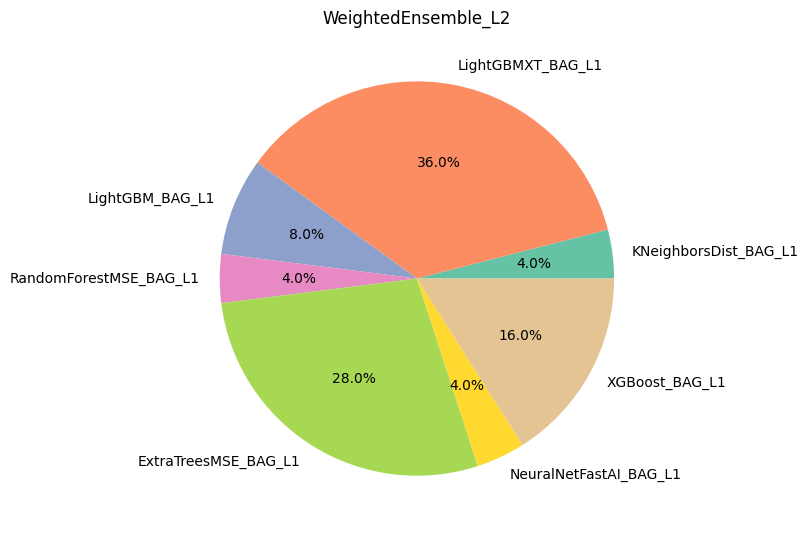

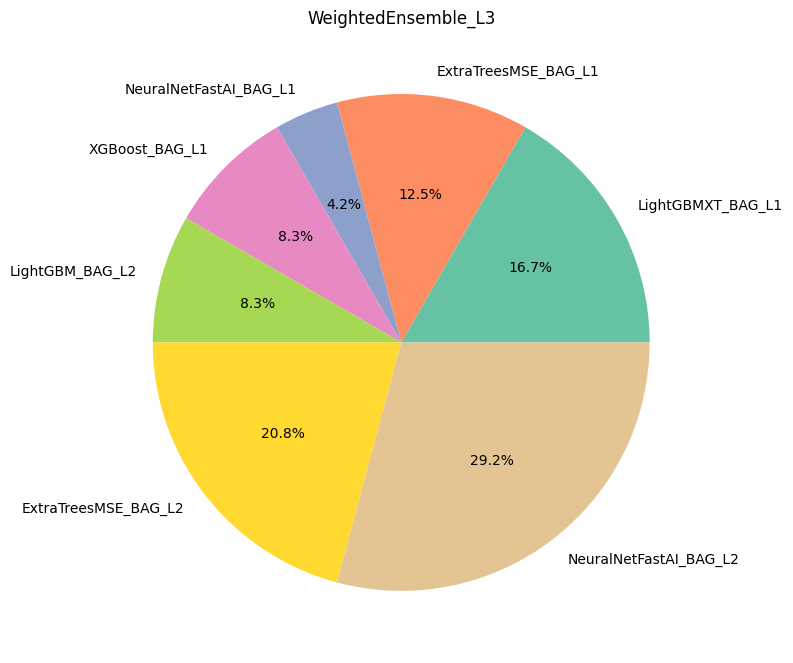

In [12]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Visualizing the results

In [13]:
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train)
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        model_oof_preds = predictor.predict_oof(model).values
        fold_score = mean_squared_error(train.loc[val_index, CFG.target], model_oof_preds[val_index], squared=False)
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

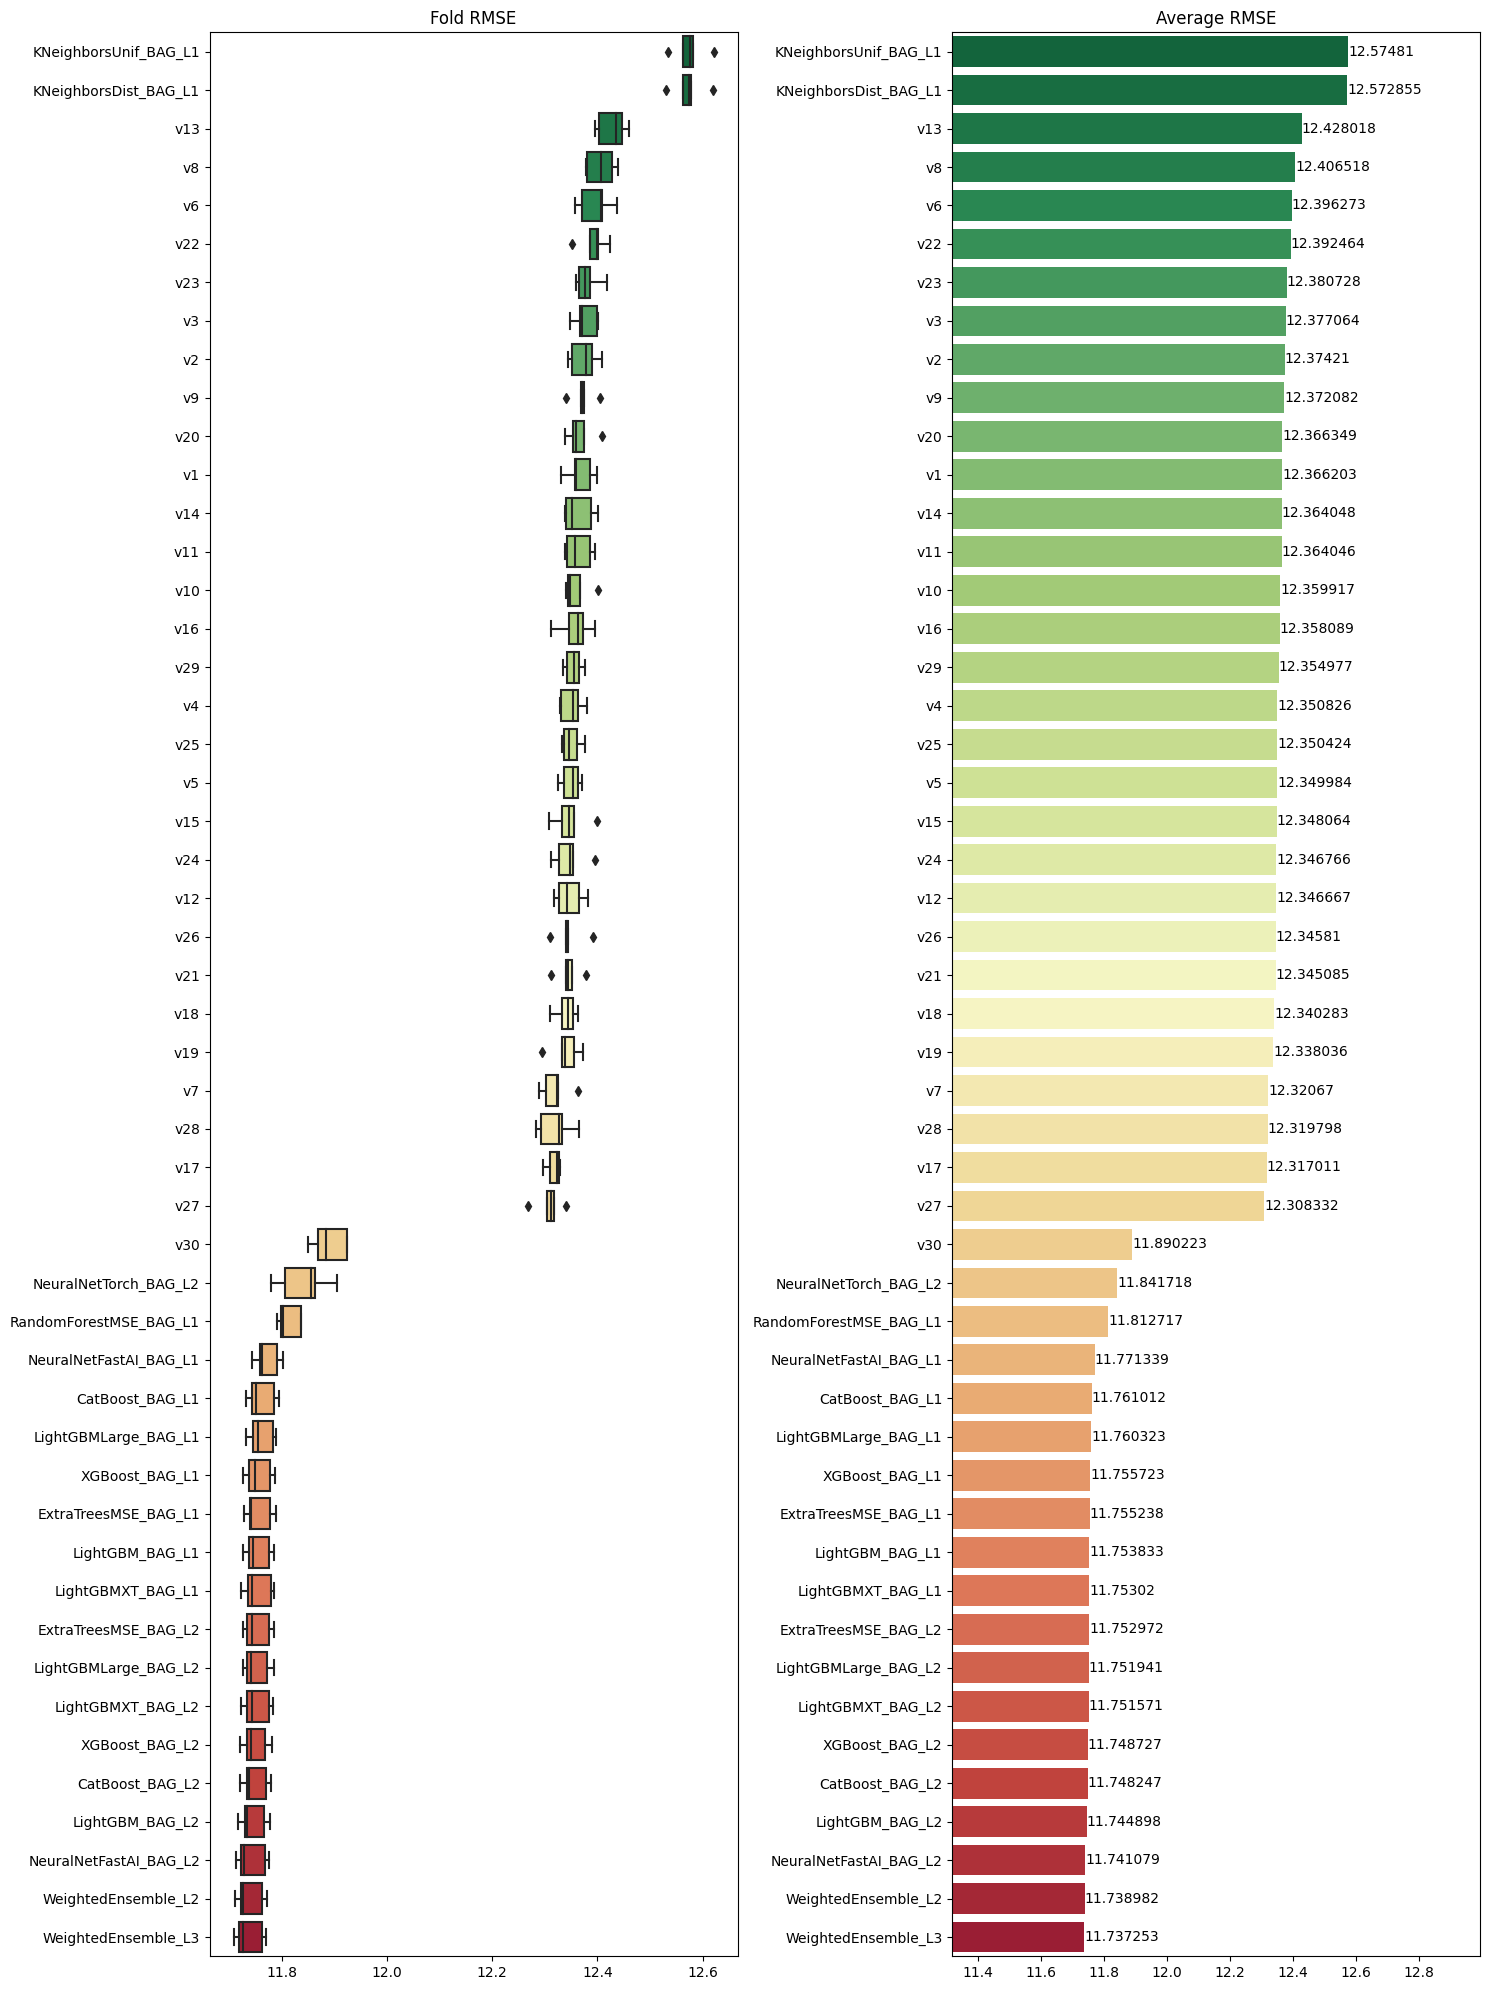

In [14]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold RMSE')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average RMSE')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

# Creating a submission file

In [15]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = predictor.predict(test).values
sub.to_csv(f'sub_autogluon_{np.mean(scores[predictor.model_best]):.6f}.csv', index=False)

INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighb

In [16]:
sub

,id,Listening_Time_minutes
0,750000,55.056961
1,750001,22.159353
2,750002,49.750820
3,750003,80.957199
4,750004,49.386040
...,...,...
249995,999995,10.355074
249996,999996,58.253319
249997,999997,6.818732
249998,999998,74.133888


In [17]:
shutil.rmtree("AutogluonModels")